# Tree cover classification using deep learning on AWS SageMaker

This notebook show how to run the [tree cover example](tree-cover-keras.ipynb) on AWS SageMaker.

Please read [these](sagemaker.md) instructions on how to setup AWS SageMaker.

In [1]:
import os
from os import path as op
import itertools

from eolearn.io import *
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, SaveToDisk, OverwritePermission
from sentinelhub import BBox, CRS, BBoxSplitter, MimeType, ServiceType

In [37]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import gzip

In [3]:
from sklearn.metrics import confusion_matrix

In [4]:
# https://www.sentinel-hub.com/faq/where-get-instance-id
INSTANCE_ID = os.environ.get('INSTANCE_ID')

In [5]:
time_interval = ('2017-01-01', '2017-12-31')
img_width = 256
img_height = 256
maxcc = 0.2

In [6]:
crs = CRS.UTM_31N
aoi = geopandas.read_file('eastern_france.geojson')
aoi = aoi.to_crs(crs={'init':CRS.ogc_string(crs)})
aoi_shape = aoi.geometry.values.tolist()[-1]

bbox_splitter = BBoxSplitter([aoi_shape], crs, (19, 10))

In [7]:
raster_value = {
    '0%': (0, [0, 0, 0, 0]),
    '10%': (1, [163, 235,  153, 255]),
    '30%': (2, [119, 195,  118, 255]),
    '50%': (3, [85, 160, 89, 255]),
    '70%': (4, [58, 130, 64, 255]),
    '90%': (5, [36, 103, 44, 255])
}

In [8]:
class MedianPixel(EOTask):
    """
    The task returns a pixelwise median value from a time-series and stores the results in a 
    timeless data array.
    """
    def __init__(self, feature, feature_out):
        self.feature_type, self.feature_name = next(self._parse_features(feature)())
        self.feature_type_out, self.feature_name_out = next(self._parse_features(feature_out)())

    def execute(self, eopatch):
        eopatch.add_feature(self.feature_type_out, self.feature_name_out, 
                            np.median(eopatch[self.feature_type][self.feature_name], axis=0))
        return eopatch

In [9]:
input_task = S2L2AWCSInput('TRUE-COLOR-S2-L2A', resx='10m', resy='10m', maxcc=0.2, instance_id=INSTANCE_ID)
# task to get ground-truth from Geopedia
geopedia_data = AddGeopediaFeature((FeatureType.MASK_TIMELESS, 'TREE_COVER'), 
                                   layer='ttl2275', theme='QP', raster_value=raster_value)
# task to compute median values
get_median_pixel = MedianPixel((FeatureType.DATA, 'TRUE-COLOR-S2-L2A'), 
                               feature_out=(FeatureType.DATA_TIMELESS, 'MEDIAN_PIXEL'))
# task to save to disk
save = SaveToDisk(op.join('data', 'eopatch'), 
                  overwrite_permission=OverwritePermission.OVERWRITE_PATCH, 
                  compress_level=2)

In [10]:
workflow = LinearWorkflow(input_task, geopedia_data, get_median_pixel, save)

In [11]:
def execute_workflow(index):
    bbox = bbox_splitter.bbox_list[index]
    info = bbox_splitter.info_list[index]
    
    patch_name = 'eopatch_{0}_row-{1}_col-{2}'.format(index, 
                                                      info['index_x'], 
                                                      info['index_y'])
    
    results = workflow.execute({input_task:{'bbox':bbox, 'time_interval':time_interval},
                                save:{'eopatch_folder':patch_name}
                               })
    return list(results.values())[-1]
    del results

In [27]:
subset_idx = len(bbox_splitter.bbox_list)
pbar = tqdm(total=subset_idx)
for idx in range(0, subset_idx):
    patch = execute_workflow(idx)
    pbar.update(1)

In [35]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-552819999234


In [29]:
inputs = sagemaker_session.upload_data(path='data/eopatch/', key_prefix='testing/eo-learn')
inputs

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-552819999234


's3://sagemaker-us-east-1-552819999234/testing/eo-learn'

In [60]:
%%file train_eo.py
import os
from os import path as op
from glob import glob
import gzip

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
K.clear_session()

from tensorflow.python.estimator.export.export import build_raw_serving_input_receiver_fn
from tensorflow.python.estimator.export.export_output import PredictOutput

INPUT_TENSOR_NAME = 'input_1'
HEIGHT = 256
WIDTH = 256
DEPTH = 3

raster_value = {
    '0%': (0, [0, 0, 0, 0]),
    '10%': (1, [163, 235,  153, 255]),
    '30%': (2, [119, 195,  118, 255]),
    '50%': (3, [85, 160, 89, 255]),
    '70%': (4, [58, 130, 64, 255]),
    '90%': (5, [36, 103, 44, 255])
}


data_path = '/opt/ml/input/data/training'
patches = glob('%s/*' % data_path)
x_train_raw = np.empty((len(patches), HEIGHT, WIDTH, DEPTH))
y_train_raw = np.empty((len(patches), HEIGHT, WIDTH, 1))
for i, patch in enumerate(patches):
    x_file = gzip.GzipFile(op.join(patch, 'data_timeless', 'MEDIAN_PIXEL.npy.gz'), 'r')
    y_file = gzip.GzipFile(op.join(patch, 'mask_timeless', 'TREE_COVER.npy.gz'), 'r')

    x_train_raw[i] = np.load(x_file)[20:276,0:256,:]
    y_train_raw[i] = np.load(y_file)[20:276,0:256,:]

img_mean = np.mean(x_train_raw, axis=(0, 1, 2))
img_std = np.std(x_train_raw, axis=(0, 1, 2))
x_train_mean = x_train_raw - img_mean
x_train = x_train_mean - img_std

train_gen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=180
)

y_train = to_categorical(y_train_raw, len(raster_value))


def _weighted_bce_loss(y_true, y_pred, weight):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
    (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def _weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def _weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    averaged_mask = K.pool2d(
            y_true, pool_size=(11, 11), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = _weighted_bce_loss(y_true, y_pred, weight) + \
    _weighted_dice_loss(y_true, y_pred, weight)
    return loss

def keras_model_fn(hyperparameters):
    inputs = Input((HEIGHT, WIDTH, DEPTH))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6])
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', 
                 kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', 
                   kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(len(raster_value), 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), 
                  loss = _weighted_bce_dice_loss, 
                  metrics = ['accuracy'])

    return model

def serving_input_fn(hyperparameters):
    """This function defines the placeholders that will be added to the model during serving.
    The function returns a tf.estimator.export.ServingInputReceiver object, which packages the 
    placeholders and the resulting feature Tensors together.
    For more information: https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#creating-a-serving_input_fn
    
    Args:
        hyperparameters: The hyperparameters passed to SageMaker TrainingJob that runs your TensorFlow 
                        training script.
    Returns: ServingInputReceiver or fn that returns a ServingInputReceiver
    """
    
    # Notice that the input placeholder has the same input shape as the Keras model input
    tensor = tf.placeholder(tf.float32, shape=[None, HEIGHT, WIDTH, DEPTH])
    
    # The inputs key INPUT_TENSOR_NAME matches the Keras InputLayer name
    inputs = {INPUT_TENSOR_NAME: tensor}
    return build_raw_serving_input_receiver_fn({INPUT_TENSOR_NAME: tensor})()
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

def train_input_fn(training_dir, hyperparameters):
    """Returns input function that would feed the model during training"""
    return _input(tf.estimator.ModeKeys.TRAIN,
                    batch_size=16, data_dir=training_dir)

def eval_input_fn(training_dir, hyperparameters):
    """Returns input function that would feed the model during evaluation"""
    return _input(tf.estimator.ModeKeys.EVAL,
                    batch_size=16, data_dir=training_dir)

def _input(mode, batch_size, data_dir):
    # example has no differentiation between train and eval
    gen_iter = train_gen.flow(x=x_train, y=y_train, batch_size=batch_size)
    images, labels = gen_iter.next()

    return {INPUT_TENSOR_NAME: images}, labels

Overwriting train_eo.py


In [62]:
from sagemaker.tensorflow import TensorFlow

custom_estimator = TensorFlow(entry_point='train_eo.py',
                               role=role,
                               framework_version='1.12.0',
                               training_steps= 1000,                                  
                               evaluation_steps= 100,
                               hyperparameters={'learning_rate': 0.001},
                               train_instance_count=1,
                               train_instance_type='ml.p2.xlarge')

custom_estimator.fit(inputs)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-552819999234
INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-2019-01-31-16-05-25-509


2019-01-31 16:05:25 Starting - Starting the training job...
2019-01-31 16:05:27 Starting - Launching requested ML instances.........
2019-01-31 16:07:06 Starting - Preparing the instances for training...
2019-01-31 16:07:50 Downloading - Downloading input data......
2019-01-31 16:08:46 Training - Downloading the training image..
2019-01-31 16:09:02,894 INFO - root - running container entrypoint
2019-01-31 16:09:02,894 INFO - root - starting train task
2019-01-31 16:09:02,917 INFO - container_support.training - Training starting
2019-01-31 16:09:10,496 INFO - tf_container - ----------------------TF_CONFIG--------------------------
2019-01-31 16:09:10,496 INFO - tf_container - {"environment": "cloud", "cluster": {"master": ["algo-1:2222"]}, "task": {"index": 0, "type": "master"}}
2019-01-31 16:09:10,496 INFO - tf_container - ---------------------------------------------------------
2019-01-31 16:09:10,497 INFO - tf_container - creating RunConfig:
2019-01-31 16:09:10,497 INFO - tf_contain

In [63]:
custom_predictor = custom_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-2019-01-31-16-05-25-509
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-2019-01-31-16-05-25-509


-----------------------------------------------------------------------------!

In [80]:
example_patch = 'eopatch_107_row-10_col-7'
example_file_x = gzip.GzipFile(op.join('data', 'eopatch', example_patch, 'data_timeless', 'MEDIAN_PIXEL.npy.gz'), 'r')
example_file_y = gzip.GzipFile(op.join('data', 'eopatch', example_patch, 'mask_timeless', 'TREE_COVER.npy.gz'), 'r')
example_file_x_array = np.load(example_file_x)[20:276,0:256,:]
example_file_y_array = np.load(example_file_y)[20:276,0:256,:]
prediction = custom_predictor.predict({ 'input_1': np.array([example_file_x_array]) })


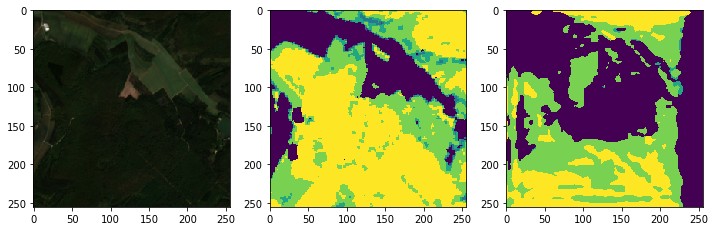

In [81]:
visual_prediction = np.argmax(np.reshape(prediction['outputs']['conv2d_22']['float_val'], (256, 256, 6)), axis=2)

fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(example_file_x_array)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(example_file_y_array[:,:,0])
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(visual_prediction)